## BaseLine

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import epsilon_greedy_policy, initialize_q_table, rec_state, rec_state_path, get_best_params, gen_dataclass
from RLOpt import ObjModel, train
from tqdm import tqdm

### Definig parameters

In [2]:
# Model parameters
params = {
            'penalty': ['l2', 'l1', 'elasticnet'], 
            'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
            'random_state': [0],
            'alpha': np.arange(0.0001, 0.01, 0.001)
        }
# Load dataset
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

data = (X_train, y_train, X_test, y_test)

In [3]:
# Enviroment parameters
env = ObjModel(SGDClassifier, params, data)     # environment
# Training parameters
learning_rate = 1          # Learning rate
max_steps = 40            # Max steps per episode
gamma = 0.9                # Discounting rate

epsilon = 1.0
decay_rate = 0.005         # Exponential decay rate for exploration prob
state_space = env.observation_space_n 
action_space = env.action_space_n

### Learning Q-Table

In [4]:
Qtable_init_s = initialize_q_table(state_space, action_space)
Qtable_s, episod_rewards_s, best_a = train(epsilon, decay_rate, env, max_steps, Qtable_init_s, gamma, learning_rate)

100% (40 of 40) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


### Evaluate results

In [5]:
best_params = get_best_params(Qtable_s, env) + [[env.get_params_by_state(best_a), best_a]]

In [6]:
states = []
vals = []
for i in best_params:
    states.append(i[1])
    vals.append(env.step(i[1])[1])
    print('State:', i[1], f'Accuracy: {env.step(i[1])[1]}')

State: 59 Accuracy: 0.96
State: 105 Accuracy: 0.98
State: 99 Accuracy: 1.0


In [7]:
print('best acc:', np.max(vals))
print('best params:', env.get_params_by_state(states[np.argmax(vals)]))

best acc: 1.0
best params: {'penalty': 'l1', 'loss': 'perceptron', 'random_state': 0, 'alpha': 0.0091}


### Plot rewards

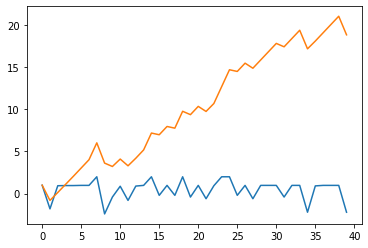

In [8]:
plt.plot(episod_rewards_s[1])
plt.plot(np.cumsum(episod_rewards_s[1]))
#plt.plot(np.diff(episod_rewards_s[0])*10)

## Optimizing fairness in LAFTR-DP model

In [9]:
from models import DP
from dataset import Dataset

### Definig parameters

In [10]:
# Model parameters
params = {
    'edepth': [2],
    'ewidths': [32],
    'adepth': [2],
    'awidths': [32],
    'cdepth': [2],
    'cwidths': [32],
    'zdim': [8, 16],
    'activ_ae': ['leakyrelu', 'softplus'],
    'activ_adv': ['leakyrelu', 'softplus'],
    'activ_class': ['leakyrelu', 'softplus'],
    'e_activ_ae': ['leakyrelu', 'softplus'],
    'e_activ_adv': ['sigmoid'],
    'e_activ_class': ['sigmoid'],
    'classweight': [1],
    'aeweight': [0, 1],
    'advweight': [1],
    'xavier': [True],
    'batch': [1024],
    'epoch' : [10],
    'adv_on_batch': [1],
    'grad_clip_ae': [0.5],
    'grad_clip_adv': [0.5],
    'grad_clip_class': [0.5],
    'seed': [0],
    'opt_ae': ['adam'],
    'opt_adv': ['adam'],
    'opt_class': ['adam'],
    'lr_ae': [0.1],
    'lr_adv': [0.1],
    'lr_class': [0.1],
    'no_cuda': [False]
}

dataset_params = {
    'only_download_data': False,
    'dataset': 'German',
    'data_dir': 'dataset'
}

data_args = gen_dataclass(dataset_params)

# Load dataset
d = Dataset(data_args)
d.download_data()

params.update({'n_features':[d.n_features()], 'n_classes': [d.n_classes()], 'n_groups': [d.n_groups()]})
data = d.dataset_preprocess(get_data=True)

In [11]:
# Enviroment parameters
env = ObjModel(DP, params, data)     # environment
# Training parameters
learning_rate = 1          # Learning rate
max_steps = 500            # Max steps per episode
gamma = 0.9                 # Discounting rate

# Exploration parameters
epsilon = 1.0
decay_rate = 0.005    
state_space = env.observation_space_n 
action_space = env.action_space_n 

In [22]:
print('Number of combintions:', action_space)

Number of combintions: 64


### Learning Q-Table

In [13]:
Qtable_init_s = initialize_q_table(state_space, action_space)
Qtable_s, episod_rewards_s, best_a = train(epsilon, decay_rate, env, max_steps, Qtable_init_s, gamma, learning_rate)

100% (500 of 500) |######################| Elapsed Time: 0:07:47 Time:  0:07:47


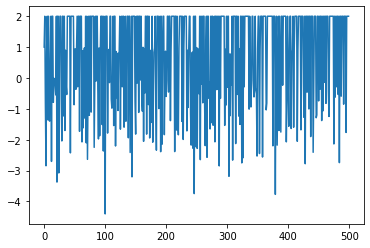

In [14]:
plt.plot(episod_rewards_s[1])
#plt.plot(np.cumsum(episod_rewards_s[1]))

## Evaluate results

In [15]:
best_params = get_best_params(Qtable_s, env) + [[env.get_params_by_state(best_a), best_a]]

In [16]:
unfair = round(1 - env.model.trainer.calc_fair_metrics(data[2], data[3], unfair=True)['unfair test'][0][2], 3)
print(f'Unfair approach - Fairness: {unfair}')
for i in best_params:
    tmp = []
    for _ in range(10):
        tmp.append(env.step(i[1])[1])
    min_ = round(np.min(tmp), 3)
    max_ = round(np.max(tmp), 3)
    mean = round(np.mean(tmp), 3)
    print('State:', i[1], f'Fairness: {min_} - {max_}; Mean value: {mean}')

Unfair approach - Fairness: 0.656
State: 29 Fairness: 0.821 - 1.0; Mean value: 0.964
State: 20 Fairness: 0.796 - 1.0; Mean value: 0.926
State: 19 Fairness: 0.751 - 1.0; Mean value: 0.947


### Random Search

In [19]:
random_states = np.random.choice(np.arange(len(Qtable_s)), (max_steps if max_steps < len(Qtable_s) else len(Qtable_s)), replace=False)
best_state = 0
best_reward = 0
for state in tqdm(random_states):
    _, reward = env.step(state)
    if reward >= best_reward:
        best_reward = reward
        best_state = state

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:58<00:00,  1.10it/s]


In [20]:
tmp = []
for _ in range(10):
    tmp.append(env.step(best_state)[1])
min_ = round(np.min(tmp), 3)
max_ = round(np.max(tmp), 3)
mean = round(np.mean(tmp), 3)
print('Random Search')
print('State:', best_state, f'Fairness: {min_} - {max_}; Mean value: {mean}')

Random Search
State: 32 Fairness: 0.674 - 1.0; Mean value: 0.854
